# Resource competition: light and Fe in the Southern Ocean

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob

import xarray as xr
import numpy as np

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
import math

### get pop grid

In [2]:
grid = pop_tools.get_grid('POP_gx1v6')

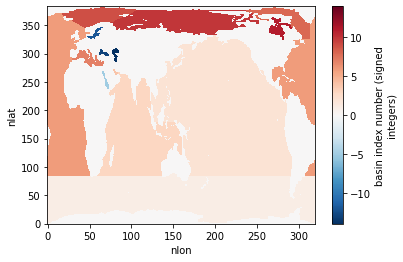

In [3]:
grid.REGION_MASK.plot()

In [4]:
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, nreg: 14, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Caspian Sea' 'Black Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -14 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v6/grid/topography_20090204.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.ieeei4
    type:               dipole
    title:              POP_gx1v6 grid

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

### DJF

In [5]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_50m','PAR_avg_50m','diatC_50m_zint','spC_50m_zint','TEMP_50m_mean']

ds_list = []
ds_DJF = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_DJFmean.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_DJF = xr.merge((ds_DJF, dsv))
    ds_list.append(ds_DJF)
    
ds_DJF['phytoC_50m_zint'] = ds_DJF.diatC_50m_zint + ds_DJF.spC_50m_zint
ds_DJF = ds_DJF.where(grid.REGION_MASK>0)

Fe_avg_50m
PAR_avg_50m
diatC_50m_zint
spC_50m_zint
TEMP_50m_mean
CPU times: user 362 ms, sys: 31.7 ms, total: 394 ms
Wall time: 881 ms


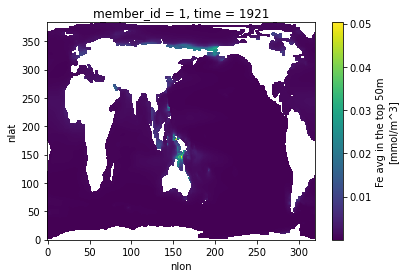

In [6]:
ds_DJF.Fe_avg_50m.sel(time=1921,member_id=1).plot()

In [7]:
ds_DJF

<xarray.Dataset>
Dimensions:          (member_id: 34, nlat: 384, nlon: 320, time: 180, z_t: 60)
Coordinates:
    TLAT             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id        (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * time             (time) int64 1921 1922 1923 1924 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz               (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    Fe_avg_50m       (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>
    PAR_avg_50m      (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>
    diatC_50m_zint   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>
    spC_50m_zint     (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>
    TEMP_50m_mean    (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>
    phytoC_50m_zint  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>

### MAM

In [8]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_50m','PAR_avg_50m','diatC_50m_zint','spC_50m_zint','TEMP_50m_mean']

ds_list = []
ds_MAM = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_MAMmean.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_MAM = xr.merge((ds_MAM, dsv))
    ds_list.append(ds_MAM)
    
ds_MAM['phytoC_50m_zint'] = ds_MAM.diatC_50m_zint + ds_MAM.spC_50m_zint
ds_MAM = ds_MAM.where(grid.REGION_MASK>0)

Fe_avg_50m
PAR_avg_50m
diatC_50m_zint
spC_50m_zint
TEMP_50m_mean
CPU times: user 375 ms, sys: 24.1 ms, total: 400 ms
Wall time: 710 ms


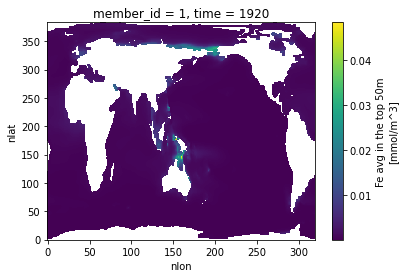

In [9]:
ds_MAM.Fe_avg_50m.isel(time=0,member_id=0).plot()

### JJA

In [10]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_50m','PAR_avg_50m','diatC_50m_zint','spC_50m_zint','TEMP_50m_mean']

ds_list = []
ds_JJA = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_JJAmean.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_JJA = xr.merge((ds_JJA, dsv))
    ds_list.append(ds_JJA)
    
ds_JJA['phytoC_50m_zint'] = ds_JJA.diatC_50m_zint + ds_JJA.spC_50m_zint
ds_JJA = ds_JJA.where(grid.REGION_MASK>0)

Fe_avg_50m
PAR_avg_50m
diatC_50m_zint
spC_50m_zint
TEMP_50m_mean
CPU times: user 395 ms, sys: 15.6 ms, total: 410 ms
Wall time: 738 ms


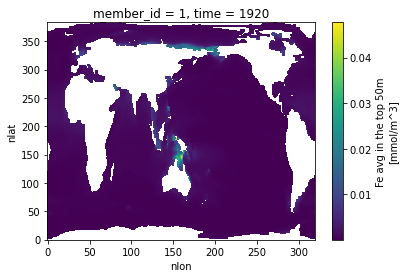

In [11]:
ds_JJA.Fe_avg_50m.isel(time=0,member_id=0).plot()

### SON

In [12]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_50m','PAR_avg_50m','diatC_50m_zint','spC_50m_zint','TEMP_50m_mean']

ds_list = []
ds_SON = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_SONmean.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_SON = xr.merge((ds_SON, dsv))
    ds_list.append(ds_SON)
    
ds_SON['phytoC_50m_zint'] = ds_SON.diatC_50m_zint + ds_SON.spC_50m_zint
ds_SON = ds_SON.where(grid.REGION_MASK>0)

Fe_avg_50m
PAR_avg_50m
diatC_50m_zint
spC_50m_zint
TEMP_50m_mean
CPU times: user 367 ms, sys: 25.2 ms, total: 393 ms
Wall time: 742 ms


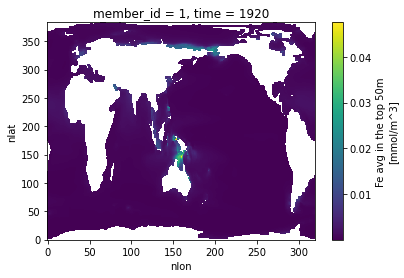

In [13]:
ds_SON.Fe_avg_50m.isel(time=0,member_id=0).plot()

### concat seasonal datasets

In [ ]:
ds = xr.concat((ds_DJF, ds_MAM, ds_JJA, ds_SON),'season')

In [ ]:
ds.Fe_avg_50m

In [ ]:
ds['season'] = ['DJF','MAM','JJA','SON'] 

In [ ]:
ds

### caveat:  no 1920 value for DJF means

In [ ]:
ds.PAR_avg_50m.sel(season='DJF',time=1920,member_id=1).plot()

#### augment list of variables

In [ ]:
variables = variables + ['phytoC_50m_zint']

### Necessary plotting function

In [ ]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [ ]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA
years = ds.time.values
years

### extract 1920s

In [ ]:
ds.time.isel(time=slice(0,10)).values

In [ ]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

In [ ]:
ds_1920s.PAR_avg_50m.isel(member_id=0,season=0).plot()

### extract 1990s

In [ ]:
ds.time.isel(time=slice(70,80)).values

In [ ]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [ ]:
ds.time.isel(time=slice(-11,-1)).values

In [ ]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

### make ensemble mean

In [ ]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_1990s = ds_1990s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

In [30]:
ensemble_mean_2090s

<xarray.Dataset>
Dimensions:          (nlat: 384, nlon: 320, season: 4, z_t: 60)
Coordinates:
    TLAT             (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG            (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
  * season           (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT              (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA            (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz               (season, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    Fe_avg_50m       (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    PAR_avg_50m      (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    diatC_50m_zint   (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    spC_50m_zint     (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TEMP_50m_mean    (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    phytoC_50m_zint  (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>

### get masks for making averages

In [31]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

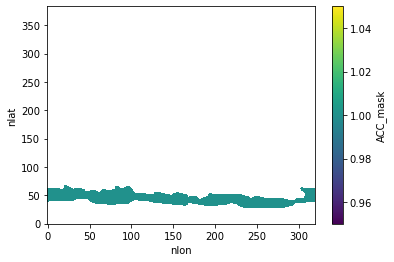

In [32]:
ds_masks.ACC_mask.plot()

### get the upper 50m average of PAR, Fe, phytoC

#### ACC

In [33]:
ACC_values_ds_1920s = xr.Dataset({v: ensemble_mean_1920s[v] for v in ['season']})
ACC_values_ds_1990s = xr.Dataset({v: ensemble_mean_1990s[v] for v in ['season']})
ACC_values_ds_2090s = xr.Dataset({v: ensemble_mean_2090s[v] for v in ['season']})


for var in variables:
    masked = ensemble_mean_1920s[var].where(ds_masks.ACC_mask==1.)
    ACC_values_ds_1920s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_1990s[var].where(ds_masks.ACC_mask==1.)
    ACC_values_ds_1990s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_2090s[var].where(ds_masks.ACC_mask==1.)
    ACC_values_ds_2090s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

#### SIZ

In [34]:
SIZ_values_ds_1920s = xr.Dataset({v: ensemble_mean_1920s[v] for v in ['season']})
SIZ_values_ds_1990s = xr.Dataset({v: ensemble_mean_1990s[v] for v in ['season']})
SIZ_values_ds_2090s = xr.Dataset({v: ensemble_mean_2090s[v] for v in ['season']})


for var in variables:
    masked = ensemble_mean_1920s[var].where(ds_masks.SIZ_mask==1.)
    SIZ_values_ds_1920s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_1990s[var].where(ds_masks.SIZ_mask==1.)
    SIZ_values_ds_1990s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_2090s[var].where(ds_masks.SIZ_mask==1.)
    SIZ_values_ds_2090s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

### check range of PAR and Fe values to make sure these are included in the resource competition plot

In [35]:
ACC_values_ds_1920s.Fe_avg_50m.values

array([0.00013736, 0.00011912, 0.00018796, 0.00022154])

In [36]:
ACC_values_ds_2090s.Fe_avg_50m.values

array([0.00014981, 0.00012938, 0.00020404, 0.00023898])

In [37]:
ACC_values_ds_1920s.PAR_avg_50m.values

array([32.44327199, 10.77240275,  4.50955436, 23.50404824])

In [38]:
ACC_values_ds_2090s.PAR_avg_50m.values

array([30.74025025, 10.46632895,  4.22066327, 22.67584248])

In [39]:
SIZ_values_ds_1920s.Fe_avg_50m.values

array([0.00014423, 0.00014033, 0.000238  , 0.0003027 ])

In [40]:
SIZ_values_ds_2090s.Fe_avg_50m.values

array([0.00011621, 0.00012481, 0.00021995, 0.00027421])

In [41]:
SIZ_values_ds_2090s.PAR_avg_50m.values

array([22.78255669,  5.71994732,  0.3283335 ,  5.69467029])

In [42]:
SIZ_values_ds_1920s.PAR_avg_50m.values

array([14.42889776,  4.4218541 ,  0.07405806,  3.54660218])

### Look how biomass varies to see how to vary the size of the points

In [43]:
ACC_values_ds_1920s.phytoC_50m_zint.values

array([164.67831886,  57.62804825,  25.68686117,  85.6222858 ])

In [44]:
ACC_values_ds_2090s.phytoC_50m_zint.values

array([152.61927714,  52.20335709,  25.38500706,  74.26030017])

In [45]:
SIZ_values_ds_1920s.phytoC_50m_zint.values

array([246.38469262,  36.33568903,   3.71588565,  34.77271566])

In [46]:
SIZ_values_ds_2090s.phytoC_50m_zint.values

array([232.17859623,  44.72712037,   6.15919659,  75.31907156])

### MAKE biomass weighted temperature for each region for each epoch

In [47]:
work = SIZ_values_ds_1920s.TEMP_50m_mean.isel(season=0) * SIZ_values_ds_1920s.phytoC_50m_zint.isel(season=0)
work = work + SIZ_values_ds_1920s.TEMP_50m_mean.isel(season=1) * SIZ_values_ds_1920s.phytoC_50m_zint.isel(season=1)
work = work + SIZ_values_ds_1920s.TEMP_50m_mean.isel(season=2) * SIZ_values_ds_1920s.phytoC_50m_zint.isel(season=2)
work = work + SIZ_values_ds_1920s.TEMP_50m_mean.isel(season=3) * SIZ_values_ds_1920s.phytoC_50m_zint.isel(season=3)
phytoC_sum = SIZ_values_ds_1920s.phytoC_50m_zint.sum(dim='season')

SIZ_temp_1920s = (work/phytoC_sum).values
SIZ_temp_1920s

array(-1.25283097)

In [48]:
work = SIZ_values_ds_1990s.TEMP_50m_mean.isel(season=0) * SIZ_values_ds_1990s.phytoC_50m_zint.isel(season=0)
work = work + SIZ_values_ds_1990s.TEMP_50m_mean.isel(season=1) * SIZ_values_ds_1990s.phytoC_50m_zint.isel(season=1)
work = work + SIZ_values_ds_1990s.TEMP_50m_mean.isel(season=2) * SIZ_values_ds_1990s.phytoC_50m_zint.isel(season=2)
work = work + SIZ_values_ds_1990s.TEMP_50m_mean.isel(season=3) * SIZ_values_ds_1990s.phytoC_50m_zint.isel(season=3)
phytoC_sum = SIZ_values_ds_1990s.phytoC_50m_zint.sum(dim='season')

SIZ_temp_1990s = (work/phytoC_sum).values
SIZ_temp_1990s

array(-1.1135154)

In [49]:
work = SIZ_values_ds_2090s.TEMP_50m_mean.isel(season=0) * SIZ_values_ds_2090s.phytoC_50m_zint.isel(season=0)
work = work + SIZ_values_ds_2090s.TEMP_50m_mean.isel(season=1) * SIZ_values_ds_2090s.phytoC_50m_zint.isel(season=1)
work = work + SIZ_values_ds_2090s.TEMP_50m_mean.isel(season=2) * SIZ_values_ds_2090s.phytoC_50m_zint.isel(season=2)
work = work + SIZ_values_ds_2090s.TEMP_50m_mean.isel(season=3) * SIZ_values_ds_2090s.phytoC_50m_zint.isel(season=3)
phytoC_sum = SIZ_values_ds_2090s.phytoC_50m_zint.sum(dim='season')

SIZ_temp_2090s = (work/phytoC_sum).values
SIZ_temp_2090s

array(-0.02824435)

In [50]:
work = ACC_values_ds_1920s.TEMP_50m_mean.isel(season=0) * ACC_values_ds_1920s.phytoC_50m_zint.isel(season=0)
work = work + ACC_values_ds_1920s.TEMP_50m_mean.isel(season=1) * ACC_values_ds_1920s.phytoC_50m_zint.isel(season=1)
work = work + ACC_values_ds_1920s.TEMP_50m_mean.isel(season=2) * ACC_values_ds_1920s.phytoC_50m_zint.isel(season=2)
work = work + ACC_values_ds_1920s.TEMP_50m_mean.isel(season=3) * ACC_values_ds_1920s.phytoC_50m_zint.isel(season=3)
phytoC_sum = ACC_values_ds_1920s.phytoC_50m_zint.sum(dim='season')

ACC_temp_1920s = (work/phytoC_sum).values
ACC_temp_1920s

array(3.86081571)

In [51]:
work = ACC_values_ds_1990s.TEMP_50m_mean.isel(season=0) * ACC_values_ds_1990s.phytoC_50m_zint.isel(season=0)
work = work + ACC_values_ds_1990s.TEMP_50m_mean.isel(season=1) * ACC_values_ds_1990s.phytoC_50m_zint.isel(season=1)
work = work + ACC_values_ds_1990s.TEMP_50m_mean.isel(season=2) * ACC_values_ds_1990s.phytoC_50m_zint.isel(season=2)
work = work + ACC_values_ds_1990s.TEMP_50m_mean.isel(season=3) * ACC_values_ds_1990s.phytoC_50m_zint.isel(season=3)
phytoC_sum = ACC_values_ds_1990s.phytoC_50m_zint.sum(dim='season')

ACC_temp_1990s = (work/phytoC_sum).values
ACC_temp_1990s

array(4.29308016)

In [52]:
work = ACC_values_ds_2090s.TEMP_50m_mean.isel(season=0) * ACC_values_ds_2090s.phytoC_50m_zint.isel(season=0)
work = work + ACC_values_ds_2090s.TEMP_50m_mean.isel(season=1) * ACC_values_ds_2090s.phytoC_50m_zint.isel(season=1)
work = work + ACC_values_ds_2090s.TEMP_50m_mean.isel(season=2) * ACC_values_ds_2090s.phytoC_50m_zint.isel(season=2)
work = work + ACC_values_ds_2090s.TEMP_50m_mean.isel(season=3) * ACC_values_ds_2090s.phytoC_50m_zint.isel(season=3)
phytoC_sum = ACC_values_ds_2090s.phytoC_50m_zint.sum(dim='season')

ACC_temp_2090s = (work/phytoC_sum).values
ACC_temp_2090s

array(7.02145321)

## start work on resource competition, parameter values are from CESM1

#### cycle through values and calculate growth rate for sp and diat, taking difference

## SIZ 1920s

In [53]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = SIZ_temp_1920s

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_SIZ1920s = np.full((100,100),np.nan)
diat_growthrate_SIZ1920s = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_SIZ1920s[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_SIZ1920s[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_SIZ1920s = xr.DataArray(sp_growthrate_SIZ1920s,dims=('par_vals','fe_vals'))
diat_growthrate_SIZ1920s = xr.DataArray(diat_growthrate_SIZ1920s,dims=('par_vals','fe_vals'))

### SIZ 1990s temp

In [54]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = SIZ_temp_1990s

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_SIZ1990s = np.full((100,100),np.nan)
diat_growthrate_SIZ1990s = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_SIZ1990s[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_SIZ1990s[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_SIZ1990s = xr.DataArray(sp_growthrate_SIZ1990s,dims=('par_vals','fe_vals'))
diat_growthrate_SIZ1990s = xr.DataArray(diat_growthrate_SIZ1990s,dims=('par_vals','fe_vals'))

### SIZ 2090s temp

In [55]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = SIZ_temp_2090s

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_SIZ2090s = np.full((100,100),np.nan)
diat_growthrate_SIZ2090s = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_SIZ2090s[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_SIZ2090s[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_SIZ2090s = xr.DataArray(sp_growthrate_SIZ2090s,dims=('par_vals','fe_vals'))
diat_growthrate_SIZ2090s = xr.DataArray(diat_growthrate_SIZ2090s,dims=('par_vals','fe_vals'))

### ACC 1920s temp

In [56]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = ACC_temp_1920s

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_ACC1920s = np.full((100,100),np.nan)
diat_growthrate_ACC1920s = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_ACC1920s[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_ACC1920s[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_ACC1920s = xr.DataArray(sp_growthrate_ACC1920s,dims=('par_vals','fe_vals'))
diat_growthrate_ACC1920s = xr.DataArray(diat_growthrate_ACC1920s,dims=('par_vals','fe_vals'))

### ACC 1990s temp

In [57]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = ACC_temp_1990s

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_ACC1990s = np.full((100,100),np.nan)
diat_growthrate_ACC1990s = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_ACC1990s[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_ACC1990s[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_ACC1990s = xr.DataArray(sp_growthrate_ACC1990s,dims=('par_vals','fe_vals'))
diat_growthrate_ACC1990s = xr.DataArray(diat_growthrate_ACC1990s,dims=('par_vals','fe_vals'))

### ACC 2090s temp

In [58]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,35,0.35)
T = ACC_temp_2090s

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_ACC2090s = np.full((100,100),np.nan)
diat_growthrate_ACC2090s = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_ACC2090s[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_ACC2090s[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_ACC2090s = xr.DataArray(sp_growthrate_ACC2090s,dims=('par_vals','fe_vals'))
diat_growthrate_ACC2090s = xr.DataArray(diat_growthrate_ACC2090s,dims=('par_vals','fe_vals'))

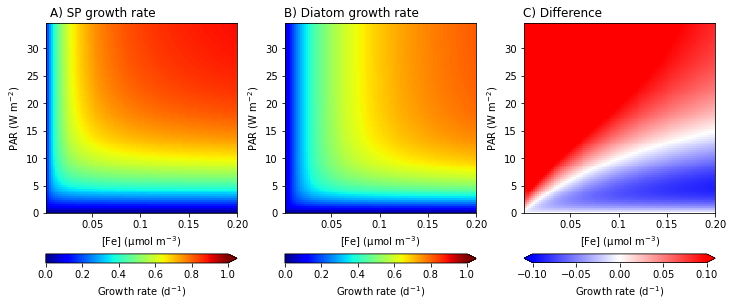

In [59]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('A) SP growth rate', x=0.3)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC2090s,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(1,3,2)
ax.set_title('B) Diatom growth rate', x=0.35)
pc=ax.pcolormesh(Fe_vals, PAR_vals, diat_growthrate_ACC2090s,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(1,3,3)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC2090s-diat_growthrate_ACC2090s,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal', ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 

plt.subplots_adjust(wspace=0.25)

fig.savefig('/glade/work/kristenk/figs/example_resource_comp.png', bbox_inches='tight', dpi=300, format='png');

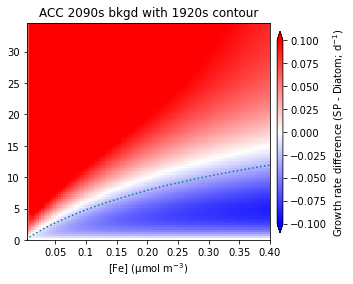

In [60]:
fig = plt.figure(figsize=(5,4))


ax = fig.add_subplot(1,1,1)
ax.set_title('ACC 2090s bkgd with 1920s contour')
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC2090s-diat_growthrate_ACC2090s,cmap='bwr',vmin=-0.1,vmax=0.1)
pci=ax.contour(Fe_vals, PAR_vals, sp_growthrate_ACC1920s-diat_growthrate_ACC1920s,levels=[0],colors='teal',linestyles='dotted')
#ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)


### color base
fig.subplots_adjust(right=0.8,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.016, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (SP - Diatom; d$^{-1}$)');

#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');

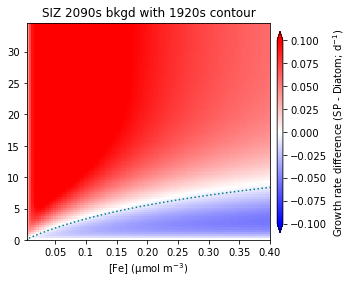

In [61]:
fig = plt.figure(figsize=(5,4))


ax = fig.add_subplot(1,1,1)
ax.set_title('SIZ 2090s bkgd with 1920s contour')
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ2090s-diat_growthrate_SIZ2090s,cmap='bwr',vmin=-0.1,vmax=0.1)
pci=ax.contour(Fe_vals, PAR_vals, sp_growthrate_SIZ1920s-diat_growthrate_SIZ1920s,colors='teal',levels=[0],linestyles='dotted')
#ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

### color base
fig.subplots_adjust(right=0.8,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.016, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (SP - Diatom; d$^{-1}$)');

#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');

### put plots together with 2090s temperature

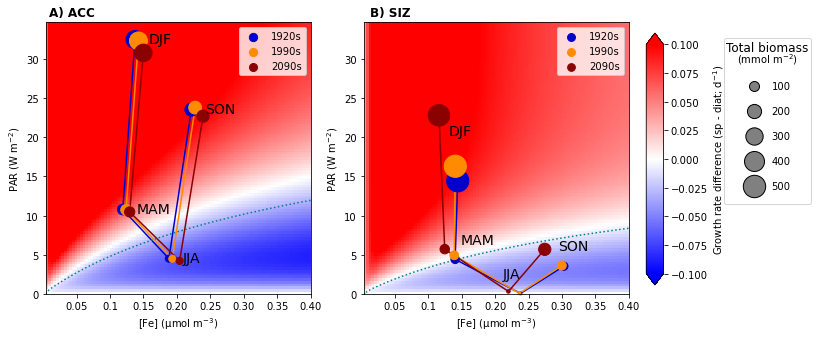

In [79]:
fig = plt.figure(figsize=(12,5))


######################################################### ACC
ax = fig.add_subplot(1,2,1)

ax.set_title('A) ACC',x=0.1,y=1, fontsize=12, fontweight='bold')
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC2090s-diat_growthrate_ACC2090s,cmap='bwr',vmin=-0.1,vmax=0.1)
pci=ax.contour(Fe_vals, PAR_vals, sp_growthrate_ACC1920s-diat_growthrate_ACC1920s,levels=[0],colors='teal',linestyles='dotted')
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')

#1920s
s = [ACC_values_ds_1920s.phytoC_50m_zint.values*2]
ax.scatter(ACC_values_ds_1920s.Fe_avg_50m.values,ACC_values_ds_1920s.PAR_avg_50m.values,
        marker='o',s=s,color='mediumblue',label='1920s', zorder=2)
ax.plot(ACC_values_ds_1920s.Fe_avg_50m.values,ACC_values_ds_1920s.PAR_avg_50m.values,
        color='mediumblue',zorder=1)
# #1990s
s = [ACC_values_ds_1990s.phytoC_50m_zint.values*2]
ax.scatter(ACC_values_ds_1990s.Fe_avg_50m.values,ACC_values_ds_1990s.PAR_avg_50m.values,
        marker='o',s=s,color='darkorange',label='1990s', zorder=2)
ax.plot(ACC_values_ds_1990s.Fe_avg_50m.values,ACC_values_ds_1990s.PAR_avg_50m.values,
        color='darkorange',zorder=1)

# #2090s
s = [ACC_values_ds_2090s.phytoC_50m_zint.values*2]
ax.scatter(ACC_values_ds_2090s.Fe_avg_50m.values,ACC_values_ds_2090s.PAR_avg_50m.values,
        marker='o',s=s,color='darkred',label='2090s',zorder=2)
ax.plot(ACC_values_ds_2090s.Fe_avg_50m.values,ACC_values_ds_2090s.PAR_avg_50m.values,
        color='darkred',zorder=1)

## add season labels
annotations = ds.season.values
for i, label in enumerate(annotations):
    plt.annotate(label, (ACC_values_ds_1920s.Fe_avg_50m.values[i]+0.00002, ACC_values_ds_1920s.PAR_avg_50m.values[i]-0.4),fontsize=14)

ax.legend(markerscale=0.6,scatterpoints=1, fontsize=10)
### add x axis labels in nmol/m3
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

######################################################### SIZ

ax = fig.add_subplot(1,2,2)

ax.set_title('B) SIZ', x=0.1,y=1, fontsize=12, fontweight='bold')
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ2090s-diat_growthrate_SIZ2090s,cmap='bwr',vmin=-0.1,vmax=0.1)
pci=ax.contour(Fe_vals, PAR_vals, sp_growthrate_SIZ1920s-diat_growthrate_SIZ1920s,colors='teal',levels=[0],linestyles='dotted')
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')

#1920s
s = [SIZ_values_ds_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_values_ds_1920s.Fe_avg_50m.values,SIZ_values_ds_1920s.PAR_avg_50m.values,
        marker='o',s=s,color='mediumblue',label='1920s',clip_on=False,zorder=2)
ax.plot(SIZ_values_ds_1920s.Fe_avg_50m.values,SIZ_values_ds_1920s.PAR_avg_50m.values,
        color='mediumblue',zorder=1)
# #1990s
s = [SIZ_values_ds_1990s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_values_ds_1990s.Fe_avg_50m.values,SIZ_values_ds_1990s.PAR_avg_50m.values,
        marker='o',s=s,color='darkorange',label='1990s',clip_on=False,zorder=2)
ax.plot(SIZ_values_ds_1990s.Fe_avg_50m.values,SIZ_values_ds_1990s.PAR_avg_50m.values,
        color='darkorange',zorder=1)
# #1990s
s = [SIZ_values_ds_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_values_ds_2090s.Fe_avg_50m.values,SIZ_values_ds_2090s.PAR_avg_50m.values,
        marker='o',s=s,color='darkred',label='2090s',clip_on=False,zorder=2)
ax.plot(SIZ_values_ds_2090s.Fe_avg_50m.values,SIZ_values_ds_2090s.PAR_avg_50m.values,
        color='darkred',zorder=1)

## add season labels
annotations = ds.season.values
# for i, label in enumerate(annotations):
#     plt.annotate(label, (SIZ_values_ds_1990s.Fe_avg_50m.values[i]+0.00001, SIZ_values_ds_1990s.PAR_avg_50m.values[i]+0.4), fontsize=14)

plt.annotate(annotations[0], (SIZ_values_ds_1990s.Fe_avg_50m.values[0]-0.00001, SIZ_values_ds_1990s.PAR_avg_50m.values[0]+4), fontsize=14)
plt.annotate(annotations[1], (SIZ_values_ds_1990s.Fe_avg_50m.values[1]+0.00001, SIZ_values_ds_1990s.PAR_avg_50m.values[1]+1.5), fontsize=14)
plt.annotate(annotations[2], (SIZ_values_ds_1990s.Fe_avg_50m.values[2]-0.000025, SIZ_values_ds_1990s.PAR_avg_50m.values[2]+2), fontsize=14)
plt.annotate(annotations[3], (SIZ_values_ds_1990s.Fe_avg_50m.values[3]-0.000005, SIZ_values_ds_1990s.PAR_avg_50m.values[3]+2), fontsize=14)

ax.legend(markerscale=0.5,scatterpoints=1, fontsize=10)

labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

#plt.annotate('Total biomass', (0.0005, 3), fontsize=14)
plt.figtext(0.912, 0.8, 'Total biomass', fontsize=12)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');

for x in [100, 200, 300, 400, 500]:
    plt.scatter([], [], c='gray', alpha=1, s=x, label=str(x), marker='o',edgecolors='black')
# legend2 = ax.legend(loc='upper center', bbox_to_anchor=(0.8, 0.8), ncol=1, fancybox=True, shadow=False, title='Biomass')

legend2 = plt.legend(loc="upper right", title="(mmol m$^{-2}$)", bbox_to_anchor=(9.8, 1),
                     fancybox=True, labelspacing=1.5, borderpad=1.3)

fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');

### Impacts of changing iron concentration

In [63]:
### Specify parameters
kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)

## initialize empty matrices
sp_Fe_lim = np.full((100),np.nan)
diat_Fe_lim = np.full((100),np.nan)

i=0

for Fe in Fe_vals: # i loop
    
    ### temperature adjusted max growth rate
    max_gr = PCref_sp * Tfunc 

    ##### small phytoplankton
    sp_Fe_lim[i] = Fe/(Fe + kFe_sp)

    #### diatoms
    diat_Fe_lim[i] = Fe/(Fe + kFe_diat)
    
    i = i + 1
    
sp_Fe_lim = xr.DataArray(sp_Fe_lim,dims=('fe_vals'))
diat_Fe_lim = xr.DataArray(diat_Fe_lim,dims=('fe_vals'))

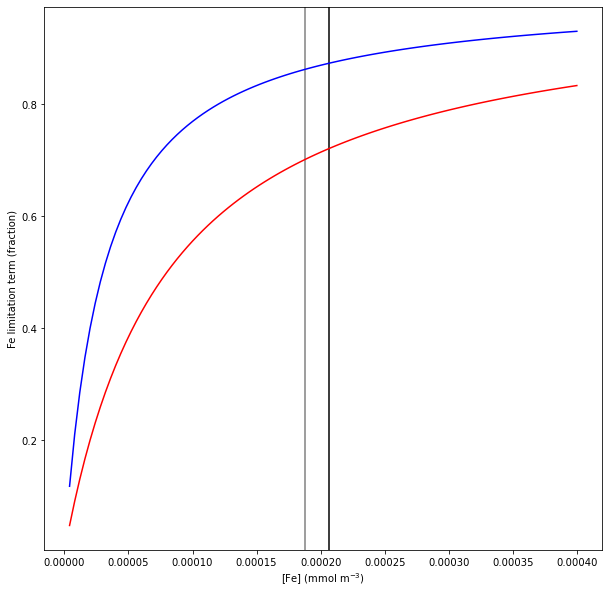

In [86]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel('[Fe] (mmol m$^{-3}$)')

### add x axis labels in umol/m3
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
          
ax.set_ylabel('Fe limitation term (fraction)')
ax.axvline(0.00018776172, color="grey") 
ax.axvline(0.00020625789, color="black") 
ax.plot(Fe_vals, diat_Fe_lim, color='red')
ax.plot(Fe_vals, sp_Fe_lim, color='blue');

In [ ]:
['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']

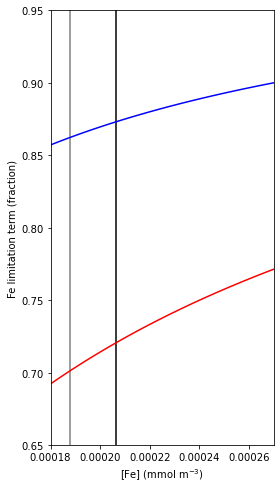

In [88]:
fig, ax = plt.subplots(figsize=(4,8))

ax.set_xlabel('[Fe] (mmol m$^{-3}$)')
ax.set_ylim(0.65,0.95)
ax.set_xlim(0.00018,0.00027)
### add x axis labels in nmol/m3
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
          
ax.set_ylabel('Fe limitation term (fraction)')
ax.axvline(0.00018776172, color="grey") 
ax.axvline(0.00020625789, color="black")  
ax.plot(Fe_vals, diat_Fe_lim, color='red')
ax.plot(Fe_vals, sp_Fe_lim, color='blue');

In [94]:
### these were calculated in NCP_Fe_lims_line_plots.ipynb (annual mean epoch diffs)

ACC_Fe_1920s = 0.00018776172
ACC_Fe_2090s = 0.00020625789

In [95]:
kFe_diat

8e-05

In [99]:
sp_Fe_lim_1920s = ACC_Fe_1920s/(ACC_Fe_1920s + kFe_sp)
sp_Fe_lim_2090s = ACC_Fe_2090s/(ACC_Fe_2090s + kFe_sp)

delta_sp = sp_Fe_lim_2090s - sp_Fe_lim_1920s

diat_Fe_lim_1920s = ACC_Fe_1920s/(ACC_Fe_1920s + kFe_diat)
diat_Fe_lim_2090s = ACC_Fe_2090s/(ACC_Fe_2090s + kFe_diat)

delta_diat = diat_Fe_lim_2090s - diat_Fe_lim_1920s
print ('SP % change in growth rate, ', 'diatom % change in growth rate')
print (delta_sp/sp_Fe_lim_1920s * 100., delta_diat/diat_Fe_lim_1920s * 100.)

SP % change in growth rate,  diatom % change in growth rate
1.2508628291367456 2.7530067398668656


In [101]:
SIZ_Fe_1920s = 0.26233891
SIZ_Fe_2090s = 0.2530094

In [102]:
sp_Fe_lim_1920s = SIZ_Fe_1920s/(SIZ_Fe_1920s + kFe_sp)
sp_Fe_lim_2090s = SIZ_Fe_2090s/(SIZ_Fe_2090s + kFe_sp)

delta_sp = sp_Fe_lim_2090s - sp_Fe_lim_1920s

diat_Fe_lim_1920s = SIZ_Fe_1920s/(SIZ_Fe_1920s + kFe_diat)
diat_Fe_lim_2090s = SIZ_Fe_2090s/(SIZ_Fe_2090s + kFe_diat)

delta_diat = diat_Fe_lim_2090s - diat_Fe_lim_1920s
print ('SP % change in growth rate, ', 'diatom % change in growth rate')
print (delta_sp/sp_Fe_lim_1920s * 100., delta_diat/diat_Fe_lim_1920s * 100.)

SP % change in growth rate,  diatom % change in growth rate
-0.00042162779229732204 -0.0011241186562148371
